In [58]:
import numpy as np
import json
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cm = 1/2.54
DPI = 600

DATA_LOCATION =  '/Users/brendan/Documents/projects/hotspot/go/data/'
IMAGE_LOCATION = '/Users/brendan/Documents/projects/hotspot/writeup/images/'


EXTINCTION_CUTOFF = 50
TRIALS = 100
N = 1000

## Plotting setup
#b0c0f7
#
colors = ["#466be3","#be89f0", "#f74a64"]
sns.set_style("ticks")
sns.set_palette(colors)
sns.color_palette()
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})   

In [93]:
with open(DATA_LOCATION + "R0Series,g=0.01,T=1000.json") as file:
    json_file = json.load(file, parse_float=lambda f: round(float(f), 2))
    
R0Series = pd.json_normalize(
json_file,
record_path=["RunSets", "Runs"],
meta=[
    "RiskMean",
    "RiskVariance",
    "ProblemPlaceFraction",
    ["RunSets", "Parameters", "R0"],
    ["RunSets", "Parameters", "RunType"]
],
)#.drop(columns=["Is", "Rts", "EffectiveAlphas", "IRisks", "SRisks"])

R0Series["Extinction Probability"] = 1.0*(R0Series["FinalR"] <= EXTINCTION_CUTOFF)
R0Series["RiskMeanCat"] = pd.Categorical(R0Series["RiskMean"])



In [94]:
def theoretical_extinction(alpha_c, alpha_r, mean_p, N=1000):
    """
    Computes theoretical extinction probability.
    """
    a, b, p = alpha_c, alpha_r, mean_p # makes the equation a little easier to write
    upper_g = 1
    lower_g = 0
    for T in range(1000):
        g = (upper_g + lower_g)/2
        g_ = p*(((1 - p*b)*(1 - a) + (1 - (1-p*b)*(1-a))*g)**N) + (1 - p)*((1 - a + a * g)**N)
        if g_ < g:
            upper_g = g
        else:
            lower_g = g
    return g

start = 0.0
end = 8.0
step = 0.1
X = np.arange(start, end + step, step)


homogeneous_extinction = []
for R0 in X:
    homogeneous_extinction.append(theoretical_extinction((R0)/N, 0, 0))

In [95]:
## Uses np.tile to replicate the control series
def tile(column):
    num_ppf = len(R0Series["ProblemPlaceFraction"].unique())
    return pd.Series(np.tile(R0Series[R0Series["ProblemPlaceFraction"] == 0][column], num_ppf))

R0Series["ExtinctionControl"] = tile("Extinction Probability")
R0Series["MaxIControl"] = tile("MaxI")
R0Series["FinalRControl"] =  tile("FinalR")

R0Series["FinalRDiff"] = R0Series["FinalR"] - R0Series["FinalRControl"]
R0Series["MaxIDiff"] = R0Series["MaxI"] - R0Series["MaxIControl"]

In [101]:
Sim = R0Series[(R0Series["RunSets.Parameters.RunType"] == "simulation")]
DifEq = R0Series[(R0Series["RunSets.Parameters.RunType"] == "difeq") & (R0Series["ProblemPlaceFraction"] != 0)]
Difference = R0Series[(R0Series["RunSets.Parameters.RunType"] == "difference") & (R0Series["ProblemPlaceFraction"] != 0)]

In [102]:
column_names = {
    "RunSets.Parameters.R0": "R0",
    "ProblemPlaceFraction": "Hot Spot Fraction",
    "RiskVariance": "Risk Distribution Variance",
    "RiskMeanCat": "Risk Distribution Mean",
    "MaxIDiff": "Peak Size Difference",
    "FinalRDiff": "Extent Difference",
}

Sim = Sim.rename(columns=column_names)


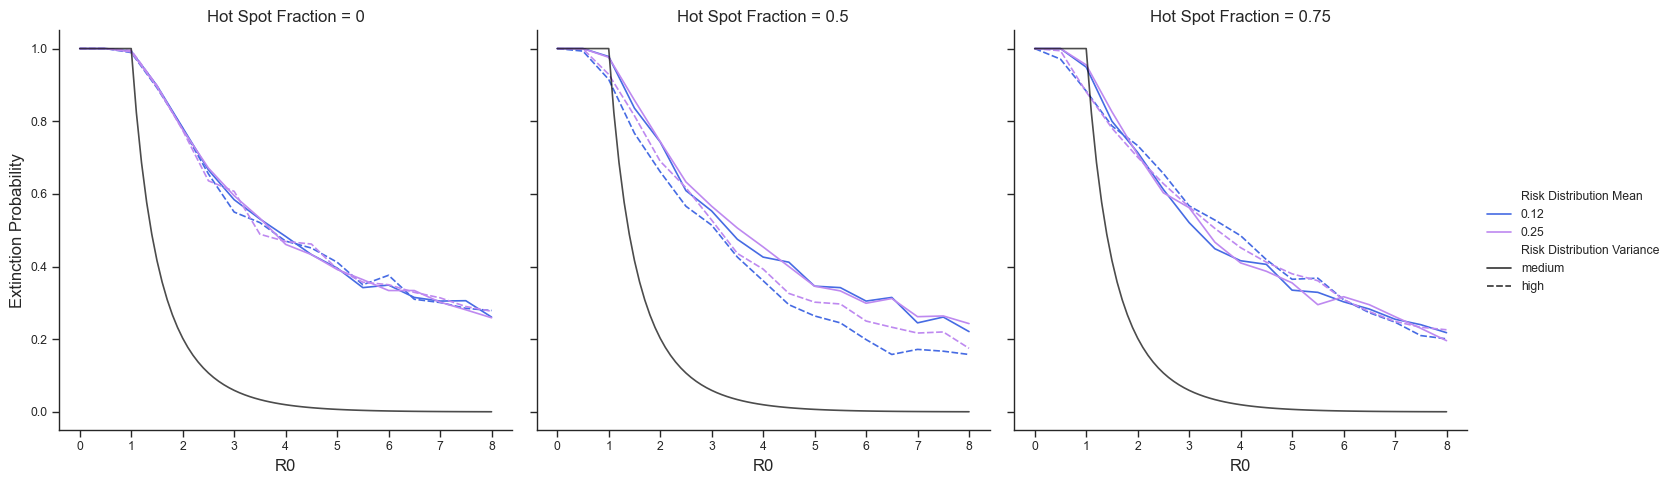

In [103]:
rp = sns.relplot(
    data=Sim,
    kind="line",
    errorbar=None,
    n_boot=None,
    y="Extinction Probability",
    x="R0",
    col="Hot Spot Fraction",
    style="Risk Distribution Variance",
    hue="Risk Distribution Mean",
)

for ax in rp.axes[0]:
    sns.lineplot(
        x=X,
        y=homogeneous_extinction,
        ax=ax,
        color="black",
        alpha=0.7,
        legend=None,
    )
#rp.savefig(IMAGE_LOCATION + "extinction.png", dpi=DPI)

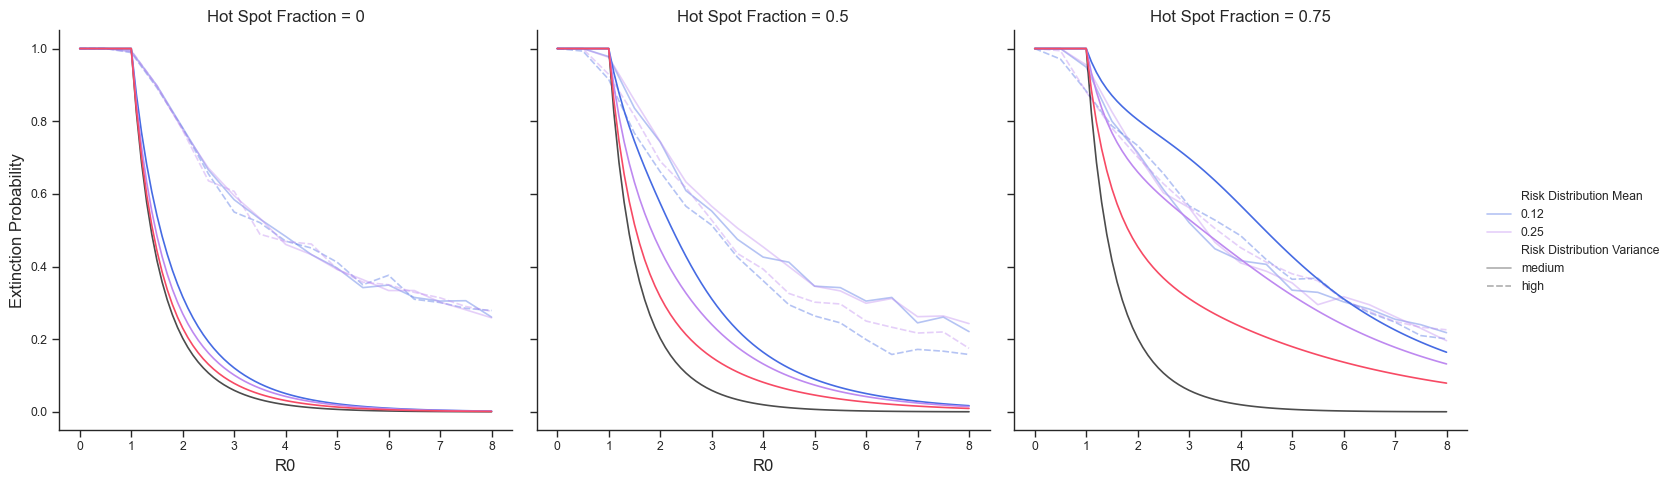

In [104]:
rp = sns.relplot(
    data=Sim,
    kind="line",
    errorbar=None,
    n_boot=None,
    y="Extinction Probability",
    x="R0",
    col="Hot Spot Fraction",
    style="Risk Distribution Variance",
    hue="Risk Distribution Mean",
    alpha=0.4,
)


for pp, problem_place in enumerate([0.25, 0.5, 0.75]):
    ## Adds the theoretical line for homogeneous case
    sns.lineplot(
        x=X,
        y=homogeneous_extinction,
        ax=rp.axes[0][pp],
        color="black",
        alpha=0.7,
        legend=None,
    )
    for rm, risk_mean in enumerate([0.125, 0.25, 0.5]): 
        Y = []
        for R0 in X:
            alpha_c = R0 / N * (1-problem_place)
            alpha_r = R0 / N * problem_place / risk_mean / risk_mean
            Y.append(theoretical_extinction(alpha_c, alpha_r, risk_mean))
        sns.lineplot(
            x=X,
            y=Y,
            ax=rp.axes[0][pp],
            color=colors[rm],
            legend=None,
        )
#rp.savefig(IMAGE_LOCATION + "extinction_theoretical.png", dpi=DPI)




In [105]:
sns.relplot(
    data=DifEq,
    kind="line",
    y="FinalRDiff",
    x="RunSets.Parameters.R0",
    col="ProblemPlaceFraction",
    style="RiskVariance",
    hue="RiskMeanCat",
)#.savefig(IMAGE_LOCATION + "FinalR.png", dpi=DPI)


sns.relplot(
    data=Sim[Sim["Extinction Probability"] == 0],
    kind="line",
    y="Extent Difference",
    x="R0",
    col="Hot Spot Fraction",
    style="Risk Distribution Variance",
    hue="Risk Distribution Mean",
)#.savefig(IMAGE_LOCATION + "FinalRSim.png", dpi=DPI)


sns.relplot(
    data=Difference,
    kind="line",
    y="FinalRDiff",
    x="RunSets.Parameters.R0",
    col="ProblemPlaceFraction",
    style="RiskVariance",
    hue="RiskMeanCat",
)#.savefig(IMAGE_LOCATION + "FinalRDifference.png", dpi=DPI)


TypeError: 'NoneType' object is not iterable

In [ ]:
sns.relplot(
    data=DifEq,
    kind="line",
    y="MaxIDiff",
    x="RunSets.Parameters.R0",
    col="ProblemPlaceFraction",
    style="RiskVariance",
    hue="RiskMeanCat",
)#.savefig(IMAGE_LOCATION + "MaxI.png", dpi=DPI)

sns.relplot(
    data=Sim[Sim["Extinction Probability"] == 0],
    kind="line",
    y="Peak Size Difference",
    x="R0",
    col="Hot Spot Fraction",
    style="Risk Distribution Variance",
    hue="Risk Distribution Mean",
)#.savefig(IMAGE_LOCATION + "MaxISim.png", dpi=DPI)


sns.relplot(
    data=Difference[Difference["Extinction Probability"] == 0],
    kind="line",
    y="MaxIDiff",
    x="RunSets.Parameters.R0",
    col="ProblemPlaceFraction",
    style="RiskVariance",
    hue="RiskMeanCat",
)#.savefig(IMAGE_LOCATION + "MaxIDifference.png", dpi=DPI)

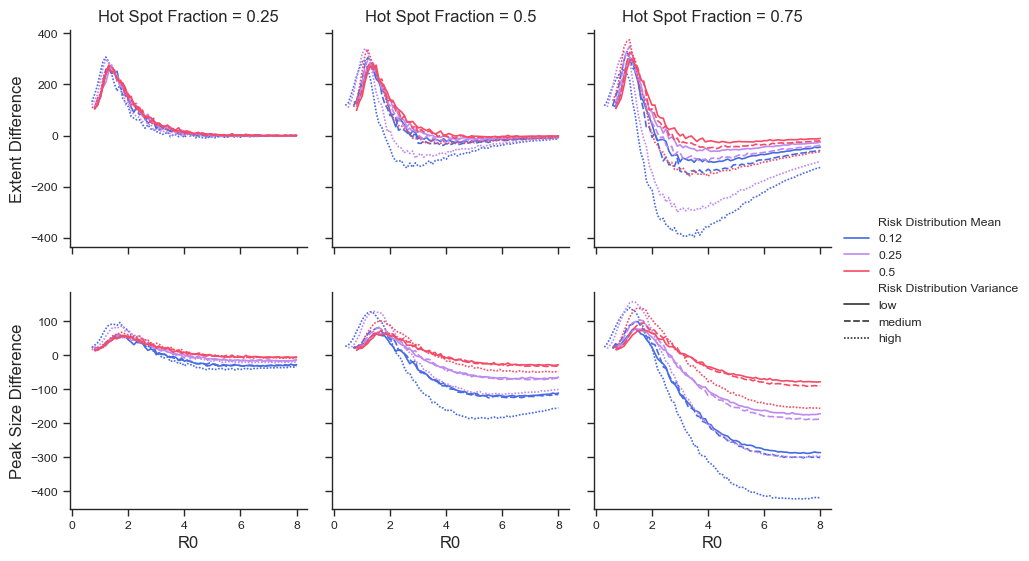

In [70]:
melt = pd.melt(Sim[Sim["Extinction Probability"] == 0], id_vars=['R0', 'Hot Spot Fraction', 'Risk Distribution Mean', 'Risk Distribution Variance'], 
                     value_vars=['Extent Difference', 'Peak Size Difference'],
                     var_name="variable", value_name="value")

outcome_plot = sns.relplot(
    data=melt,
    row="variable",
    y="value",
    x="R0",
    kind="line",
    col="Hot Spot Fraction",
    errorbar=None,
    hue="Risk Distribution Mean",
    style="Risk Distribution Variance",
    facet_kws={"sharey":"row"},
    height=11*cm*2/3,
    aspect=1.0,
)

# for row in outcome_plot.axes:
#     for ax in row:
#         title = ax.title.get_text()
#         ax.set_title(title.split(" | ")[1])
#     #row[0].set_ylabel(title.split(" | ")[0].replace("variable = ", ""))
# outcome_plot.fig

outcome_plot.axes[0][0].set_ylabel("Extent Difference")
outcome_plot.axes[1][0].set_ylabel("Peak Size Difference")

hs_fractions=["0.25", "0.5", "0.75"]
for i, ax in enumerate(outcome_plot.axes[0]):
    ax.set_title("Hot Spot Fraction = {}".format(hs_fractions[i]))
for ax in outcome_plot.axes[1]:
    ax.set_title("")
    
#outcome_plot.fig

outcome_plot.savefig(IMAGE_LOCATION + 'figure3.png', format='png', dpi=DPI)